Using an CNN Autoencoder to cluster column maxes for each track, to cluster together protons + deuterons and noise. 

Data created in **padded_data.ipynb** which uses data created in **clusters_data.ipynb**.

Might be a better idea to use a small sample of only protons, handpicked, with no muons. 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader 

import numpy as np
import matplotlib.pyplot as plt

In [2]:
PATH_ALL = "/Users/user/data/research/proton-deuteron/csv/padded_max_adc_columns.npy"
PROTONS = '/Users/user/data/research/proton-deuteron/csv/padded_protons.npy'
DEUTERONS = '/Users/user/data/research/proton-deuteron/csv/padded_deuterons.npy'

In [3]:
# threshold: 15 ADC, for making clusters of connected pixels.
# then, max ADC of each wire in cluster is recorded only in a 1D matrix.
# then this array is padded with zeros on either side, with original wire coordinates preserved.
# cut: wire lengths > 10 only, mixed collection, induction, proton, deuteron candidates.
# full data, pre-training/testing split. 
# 1D data, (1x240), 70922 total data points (16097 proton candidates, 54825 deuterons candidates), collection, induction mixed.   

padded_all = np.load(PATH_ALL)
padded_protons = np.load(PROTONS) 
padded_deuterons = np.load(DEUTERONS)

# CNN Autoencoder. 

Uses CNNs as encoder and decoder. 

In [6]:
class CAE(nn.Module):
    def __init__(self, input=240, latent=8):
        super(CAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv1d(1, 32, 5, stride=2, padding=2), nn.BatchNorm1d(32), nn.ReLU(), 
            nn.Conv1d(32, 64, 5, stride=2, padding=2), nn.BatchNorm1d(64), nn.ReLU(),
            nn.Conv1d(64, 128, 5, stride=2, padding=2), nn.BatchNorm1d(128), nn.ReLU(),
            nn.Conv1d(128, 256, 5, stride=2, padding=2), nn.BatchNorm1d(256), nn.ReLU()
        )

        self.fc_enc = nn.Linear(256 * (input // 16), latent)

        self.fc_dec = nn.Linear(latent, 256 * (input // 16))

        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(256, 128, 5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.ConvTranspose1d(128, 64, 5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.ConvTranspose1d(64, 32, 5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.ConvTranspose1d(32, 1, 5, stride=2, padding=2, output_padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        x = x.unsqueeze(1)
        z = self.encoder(x).flatten(1)
        z = self.fc_enc(z)
        y = self.fc_dec(z).view(x.size(0), 256, -1)
        y = self.decoder(y).squeeze(1)
        return y

In [6]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device

device(type='mps')

In [7]:
model = CAE().to(device)
optim  = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
loss_fn = nn.MSELoss()

In [8]:
X = torch.tensor(padded_protons, dtype=torch.float32).to(device)
train_loader = torch.utils.data.DataLoader(X, batch_size=256, shuffle=True)
epochs = 50

In [9]:
for epoch in range(epochs):
    model.train()
    for xb in train_loader:
        xb = xb.to(device)
        optim.zero_grad()
        preds = model(xb)
        loss = loss_fn(preds, xb)
        loss.backward()
        optim.step()
    print(f"Epoch {epoch+1}: loss = {loss.item():.4f}")

Epoch 1: loss = 7943.7627
Epoch 2: loss = 7194.7432
Epoch 3: loss = 6012.2476
Epoch 4: loss = 4643.0332
Epoch 5: loss = 3551.9199
Epoch 6: loss = 2572.8879
Epoch 7: loss = 2363.5916
Epoch 8: loss = 1274.0669
Epoch 9: loss = 708.9203
Epoch 10: loss = 606.7474
Epoch 11: loss = 543.7733
Epoch 12: loss = 457.4375
Epoch 13: loss = 211.7073
Epoch 14: loss = 226.9800
Epoch 15: loss = 227.4713
Epoch 16: loss = 236.2654
Epoch 17: loss = 217.5754
Epoch 18: loss = 199.1351
Epoch 19: loss = 214.0684
Epoch 20: loss = 201.4424
Epoch 21: loss = 181.2470
Epoch 22: loss = 208.9943
Epoch 23: loss = 171.2921
Epoch 24: loss = 219.6487
Epoch 25: loss = 141.0910
Epoch 26: loss = 131.4893
Epoch 27: loss = 168.4891
Epoch 28: loss = 169.0364
Epoch 29: loss = 157.8988
Epoch 30: loss = 149.7110
Epoch 31: loss = 124.6166
Epoch 32: loss = 137.0129
Epoch 33: loss = 138.8440
Epoch 34: loss = 127.2246
Epoch 35: loss = 204.4786
Epoch 36: loss = 157.3678
Epoch 37: loss = 156.1500
Epoch 38: loss = 102.1683
Epoch 39: los

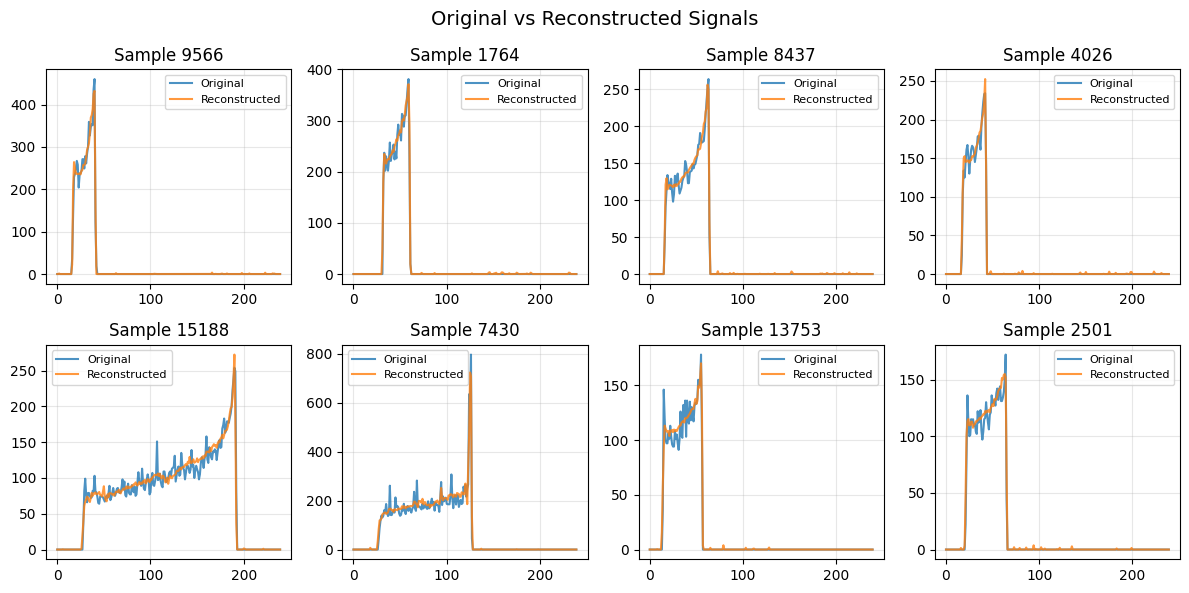

In [10]:
model.eval()

N = 8
X_cpu = X.detach().cpu().numpy()             # full dataset, shape (N_total, 240)
sample_idx = np.random.choice(len(X_cpu), N, replace=False)
X_sample = X[sample_idx].to(device)          # shape (N, 240)

# Run through model
with torch.no_grad():
    recons = model(X_sample).cpu().numpy()   # shape (N, 240)

# Original signals
X_orig = X_sample.cpu().numpy()

# Plot
plt.figure(figsize=(12, 6))
for i in range(N):
    plt.subplot(2, N // 2, i + 1)
    plt.plot(X_orig[i], label='Original', alpha=0.8)
    plt.plot(recons[i], label='Reconstructed', alpha=0.8)
    plt.title(f"Sample {sample_idx[i]}")
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=8)
plt.suptitle("Original vs Reconstructed Signals", fontsize=14)
plt.tight_layout()
plt.show()


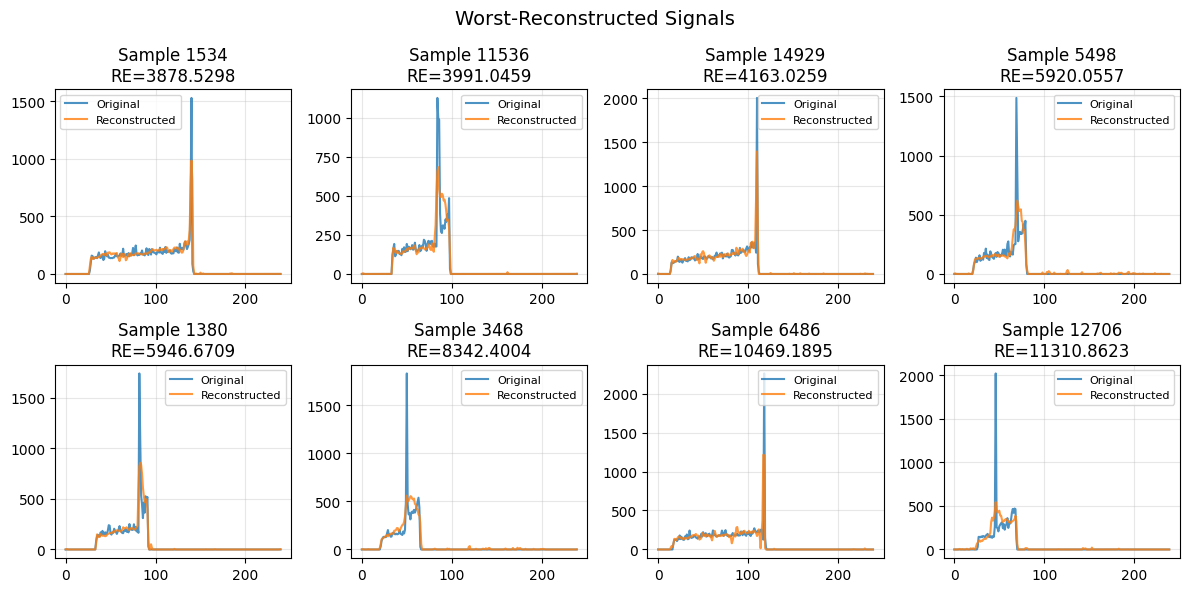

In [12]:
model.eval()

# Compute full reconstruction and REs
with torch.no_grad():
    recon_all = model(X)                  # shape (N, 240)
    re = F.mse_loss(recon_all, X, reduction='none')  # shape (N, 240)
    RE_per_sample = re.mean(dim=1).cpu().numpy()     # shape (N,)

# Sort by highest RE
worst_idx = np.argsort(RE_per_sample)[-8:]  # top 8 worst

# Get originals and recons
X_worst = X[worst_idx].cpu().numpy()
recon_worst = recon_all[worst_idx].cpu().numpy()

# Plot
plt.figure(figsize=(12, 6))
for i in range(len(worst_idx)):
    plt.subplot(2, 4, i + 1)
    plt.plot(X_worst[i], label='Original', alpha=0.8)
    plt.plot(recon_worst[i], label='Reconstructed', alpha=0.8)
    plt.title(f"Sample {worst_idx[i]}\nRE={RE_per_sample[worst_idx[i]]:.4f}")
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=8)
plt.suptitle("Worst-Reconstructed Signals", fontsize=14)
plt.tight_layout()
plt.show()

In [13]:
with torch.no_grad():
    recons = model(X)  # X shape: (N, 240)
    mse = F.mse_loss(recons, X, reduction='none')  # shape (N, 240)
    RE_per_sample = mse.mean(dim=1).cpu().numpy()  # shape (N,)

with torch.no_grad():
    z_all = model.encoder(X.unsqueeze(1))     # (N, 1, 240) → (N, 64, 60)
    z_all = z_all.flatten(1)                  # flatten to (N, 64*60)
    latent_vectors = model.fc_enc(z_all).cpu().numpy()

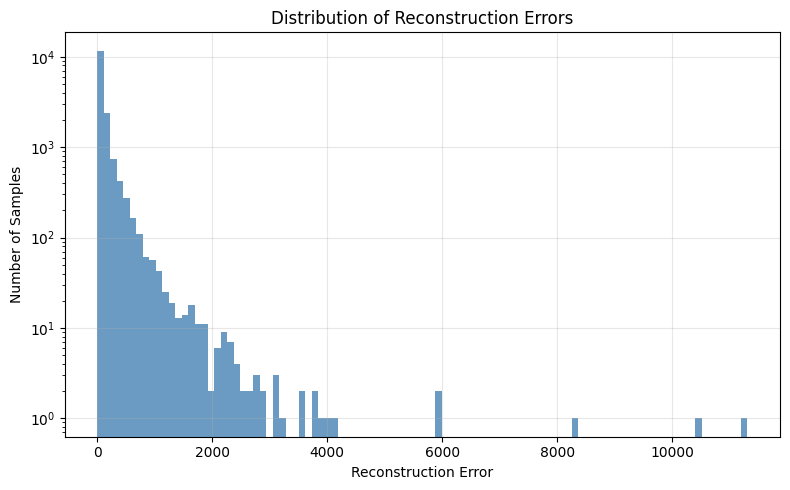

In [ ]:
plt.figure(figsize=(8, 5))
plt.hist(RE_per_sample, bins=100, color='steelblue', alpha=0.8)
plt.xlabel("Reconstruction Error")
plt.ylabel("Number of Samples")
plt.title("Distribution of Reconstruction Errors")
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.tight_layout()
plt.show()

In [15]:
from sklearn.preprocessing import StandardScaler

features = np.concatenate([RE_per_sample.reshape(-1, 1), latent_vectors], axis=1)
# features = latent_vectors

scaler   = StandardScaler()
X_scaled = scaler.fit_transform(features)

In [16]:
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=100,     # tune5–20
                            min_samples=None,        # default = min_cluster_size
                            metric='euclidean',
                            cluster_selection_method='eom')
labels = clusterer.fit_predict(X_scaled)             # -1 = noise
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(f"Found {n_clusters} clusters (+ noise)")


/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Found 2 clusters (+ noise)


In [158]:
from sklearn.mixture import BayesianGaussianMixture
bgmm = BayesianGaussianMixture(n_components=4, weight_concentration_prior_type='dirichlet_process')
labels = bgmm.fit_predict(X_scaled)

/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-pac

In [176]:
from sklearn.cluster import SpectralClustering
labels = SpectralClustering(n_clusters=3, affinity='nearest_neighbors').fit_predict(X_scaled)

/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-pac

In [180]:
from sklearn.cluster import AgglomerativeClustering
labels = AgglomerativeClustering(n_clusters=3, linkage='ward').fit_predict(X_scaled)

In [289]:
from sklearn.manifold import TSNE

proj = TSNE(n_components=2, perplexity=85, random_state=0).fit_transform(X_scaled)

/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packag

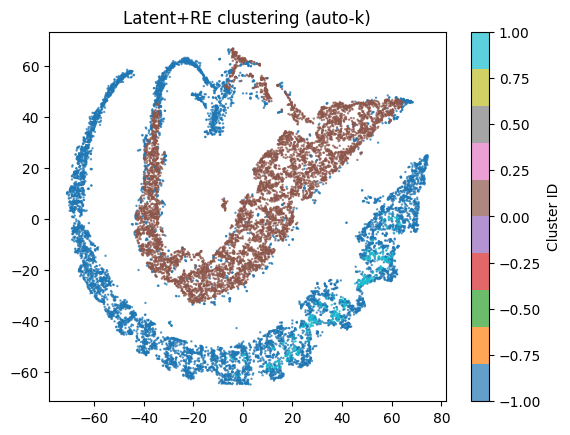

In [290]:
plt.scatter(proj[:, 0], proj[:, 1], c=labels, cmap='tab10', alpha=0.7, s=0.5)
plt.title("Latent+RE clustering (auto-k)")
plt.colorbar(label="Cluster ID")
plt.show()

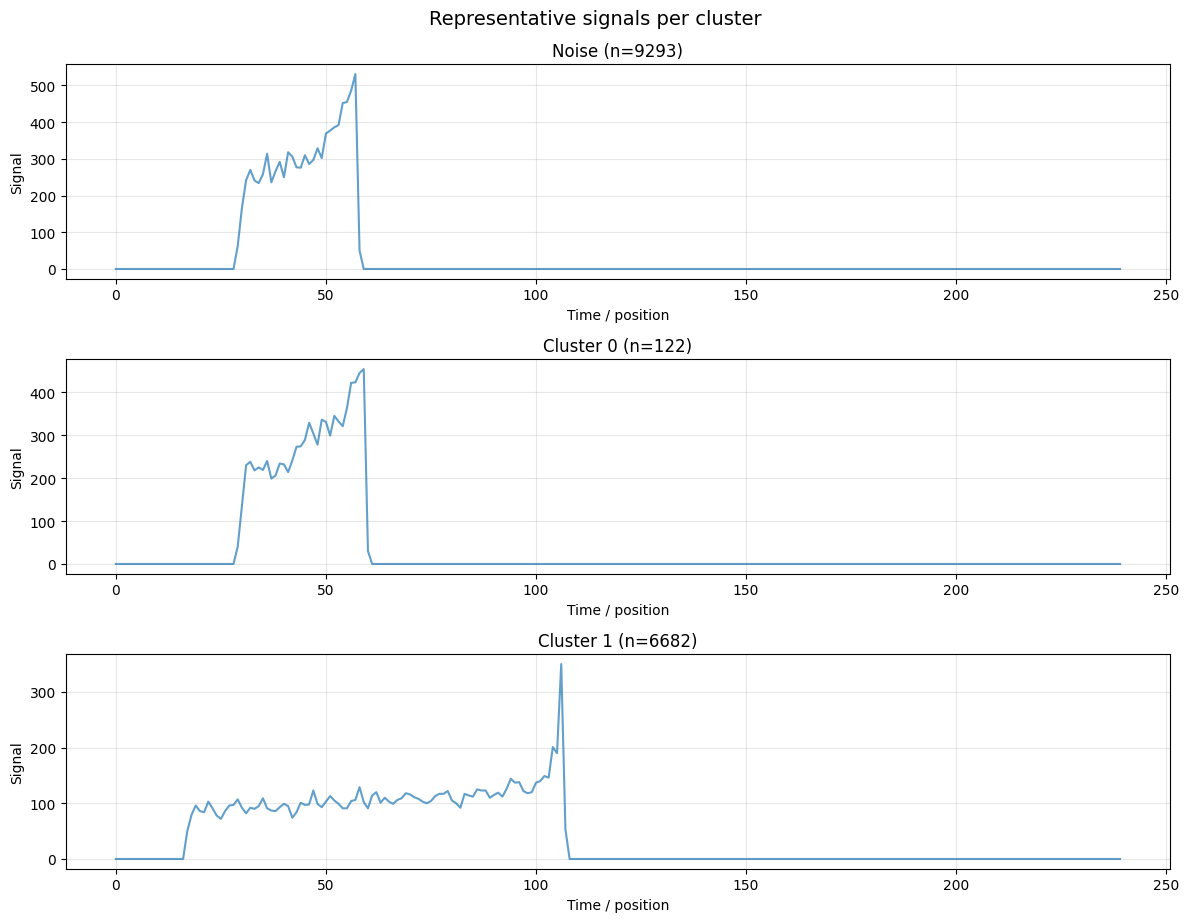

In [17]:
# ── prep data ──────────────────────────────────────────
X_np = X.cpu().numpy()            # original signals, shape (N, 240)
unique_labels = np.unique(labels) # e.g. [-1, 0, 1, 2, …]

# how many examples to show per cluster
n_plot = 1                     # adjust as you like

# set up a subplot row per cluster
n_rows = len(unique_labels)
fig, axes = plt.subplots(n_rows, 1, figsize=(12, 3 * n_rows))

if n_rows == 1:                   # when there’s only one cluster
    axes = [axes]

# ── loop over clusters ─────────────────────────────────
for ax, cid in zip(axes, unique_labels):
    mask   = labels == cid
    count  = mask.sum()
    sample = X_np[mask]

    # pick up to n_plot random examples
    k = min(n_plot, count)
    if k > 0:
        idx = np.random.choice(count, k, replace=False)
        for sig in sample[idx]:
            ax.plot(sig, alpha=0.7)

    title = f"Cluster {cid} (n={count})" if cid != -1 else f"Noise (n={count})"
    ax.set_title(title)
    ax.set_xlabel("Time / position")
    ax.set_ylabel("Signal")
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle("Representative signals per cluster", y=1.02, fontsize=14)
plt.show()

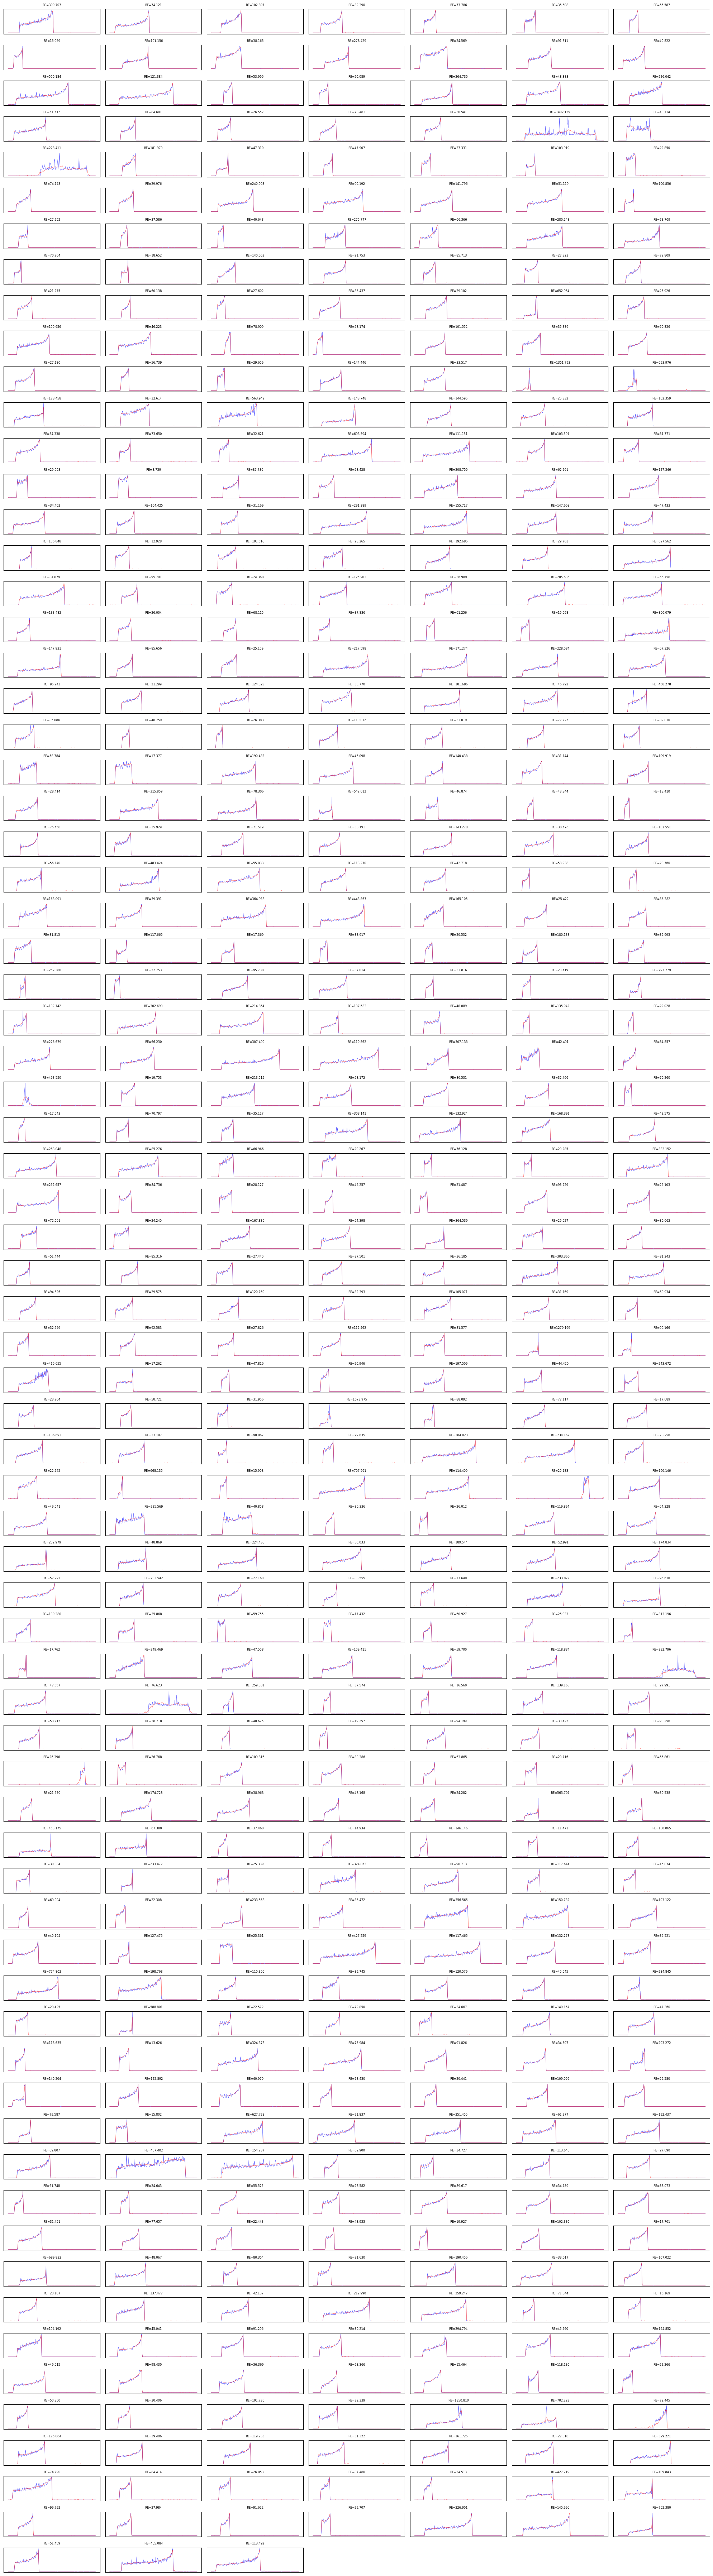

In [24]:
# Create tiny plots of all signals and their reconstructions with RE
model.eval()

# Get all reconstructions and REs
with torch.no_grad():
    recon_all = model(X)
    re = F.mse_loss(recon_all, X, reduction='none')
    RE_per_sample = re.mean(dim=1).cpu().numpy()

# Convert to numpy
X_np = X.cpu().numpy()
recon_np = recon_all.cpu().numpy()

# Create a grid of tiny plots
n_samples = 500 # len(X_np)
cols = 7  # Number of columns
rows = (n_samples + cols - 1) // cols  # Calculate rows needed

fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 1))
axes = axes.flatten()

for i in range(n_samples):
    ax = axes[i]
    
    # Plot original and reconstruction
    ax.plot(X_np[i], 'b-', alpha=0.7, linewidth=0.5, label='Orig')
    ax.plot(recon_np[i], 'r-', alpha=0.7, linewidth=0.5, label='Recon')
    
    # Add RE as title
    ax.set_title(f'RE={RE_per_sample[i]:.3f}', fontsize=6)
    
    # Remove ticks and labels for cleaner look
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(True, alpha=0.3)

# Hide unused subplots
for i in range(n_samples, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
# plt.suptitle(f'All {n_samples} Proton Signals: Original (blue) vs Reconstructed (red)', 
             # fontsize=14, y=0.98)
plt.show()

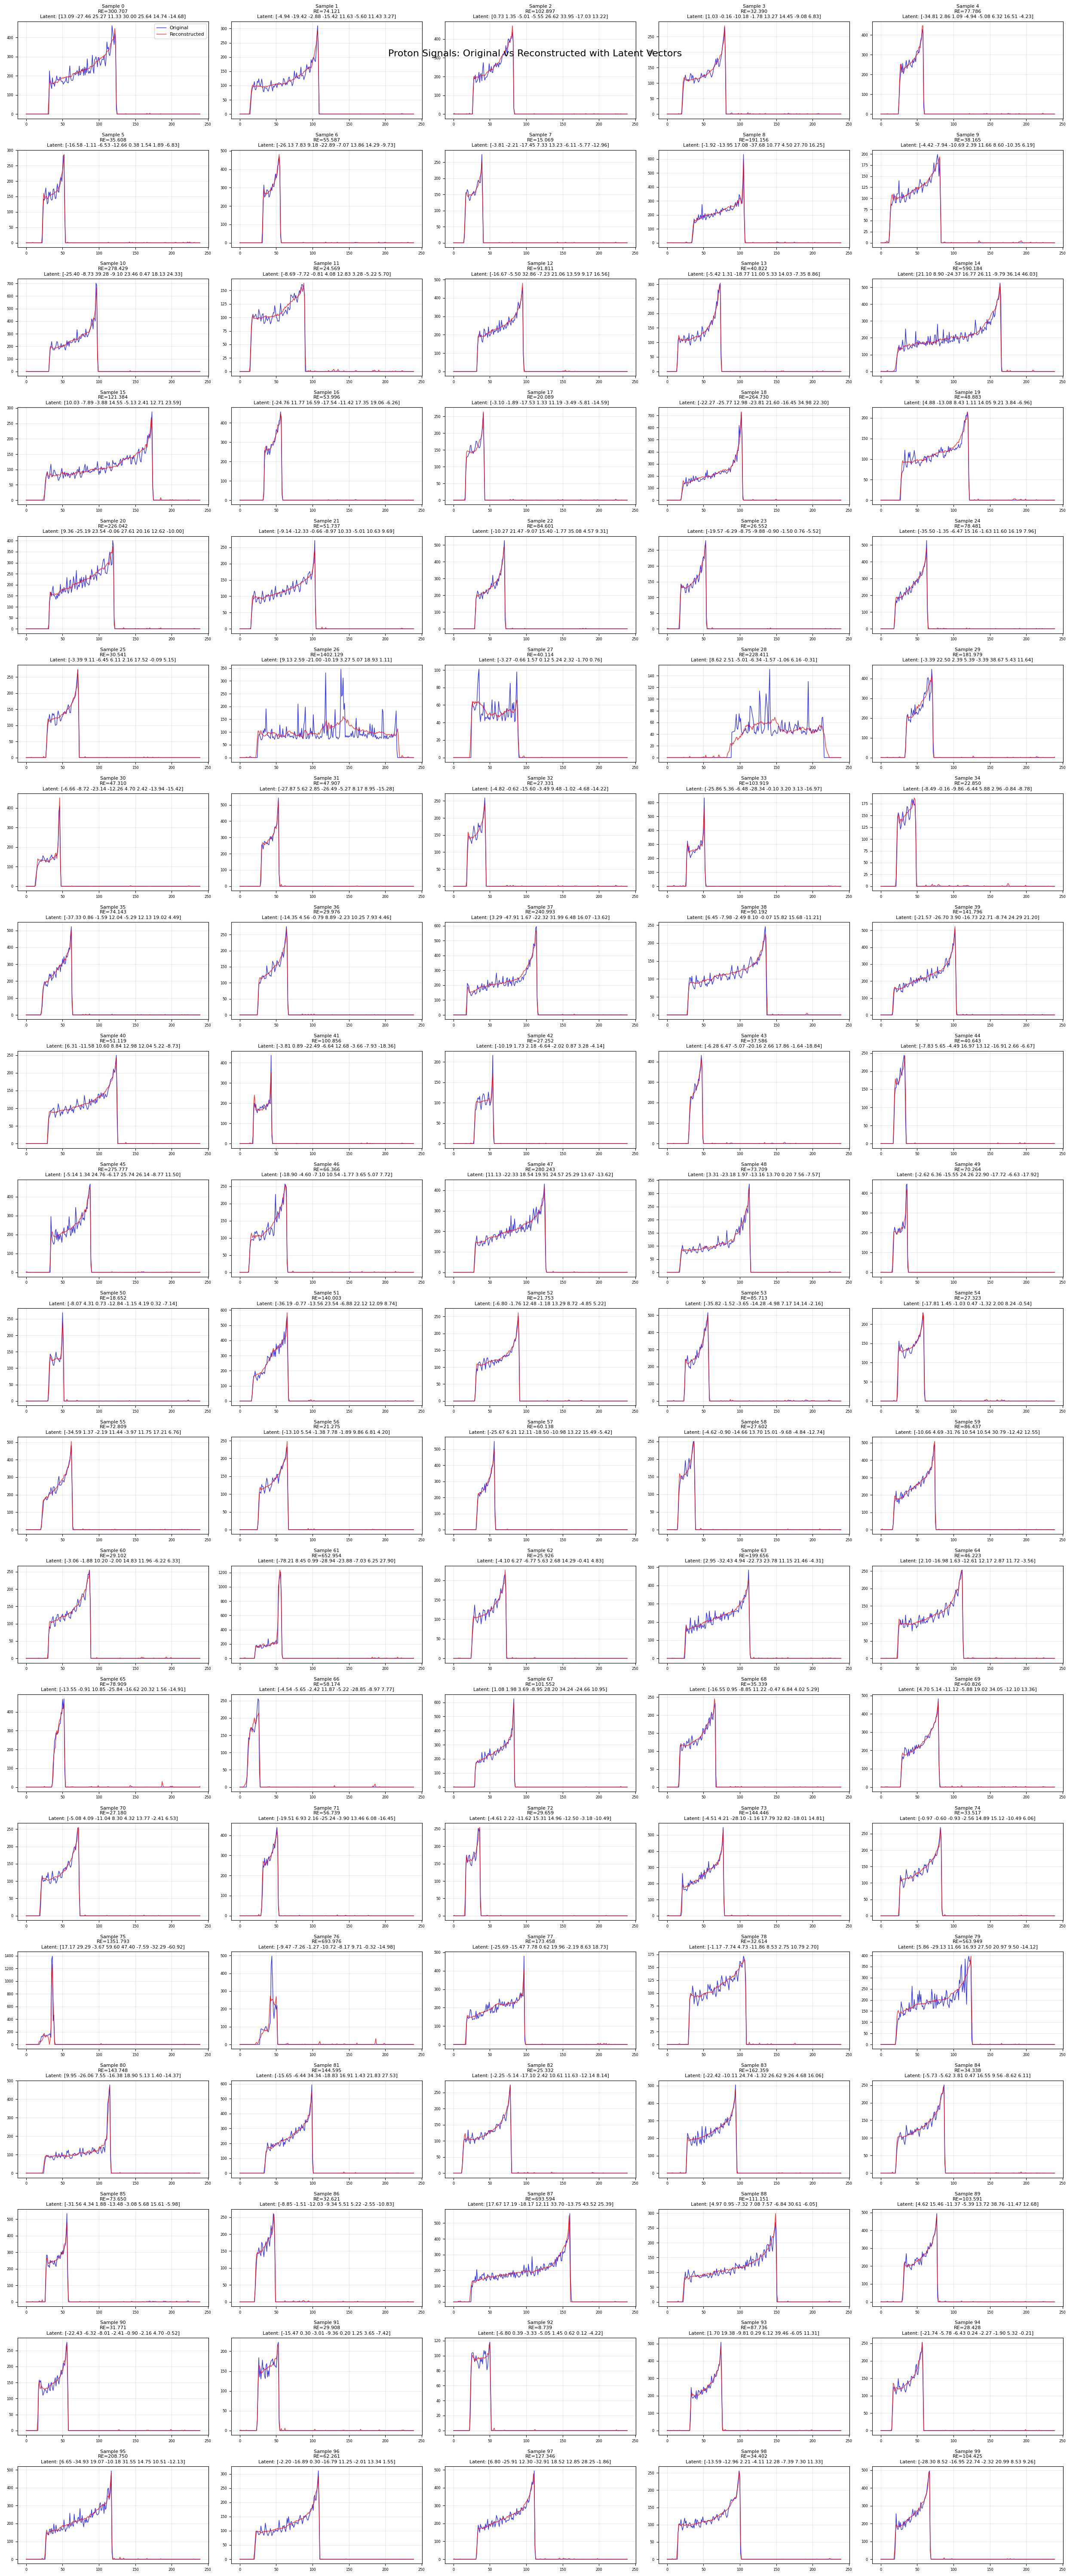

In [64]:
# Create plots showing signals, reconstructions, and latent representations
model.eval()

# Get all reconstructions, REs, and latent vectors
with torch.no_grad():
    recon_all = model(X)
    re = F.mse_loss(recon_all, X, reduction='none')
    RE_per_sample = re.mean(dim=1).cpu().numpy()
    
    # Get latent vectors
    z_all = model.encoder(X.unsqueeze(1))
    z_all = z_all.flatten(1)
    latent_vectors = model.fc_enc(z_all).cpu().numpy()  # Shape: (N, latent_dim)

# Convert to numpy
X_np = X.cpu().numpy()
recon_np = recon_all.cpu().numpy()

# Create a grid showing original, reconstruction, and latent
n_samples = 100  # Fewer samples for readability
cols = 5
rows = (n_samples + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(25, rows * 3))
axes = axes.flatten()

for i in range(n_samples):
    ax = axes[i]
    
    # Plot original and reconstruction
    ax.plot(X_np[i], 'b-', alpha=0.8, linewidth=1, label='Original')
    ax.plot(recon_np[i], 'r-', alpha=0.8, linewidth=1, label='Reconstructed')
    
    # Add latent vector as text
    latent_str = ' '.join([f'{val:.2f}' for val in latent_vectors[i]])
    
    ax.set_title(f'Sample {i}\nRE={RE_per_sample[i]:.3f}\nLatent: [{latent_str}]', 
                fontsize=8)
    
    ax.tick_params(axis='both', which='major', labelsize=6)
    ax.grid(True, alpha=0.3)
    
    if i == 0:
        ax.legend(fontsize=8)

# Hide unused subplots
for i in range(n_samples, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.suptitle('Proton Signals: Original vs Reconstructed with Latent Vectors', 
             fontsize=16, y=0.98)
plt.show()

In [ ]:
init = np.array([
    [ 9.13,  2.59, -21.00, -10.19,  3.27,  5.07, 18.93,  1.11], # noise
    [-6.80, -1.76,  12.48,  -1.18, 13.29,  8.72, -4.85,  5.22], # proton
    [8.62, 2.51, 5.01, 6.34, -1.57, -1.06, 6.16, -0.31],        # noise
    [3.27, -0.66, 1.57, 0.12, 5.24, 2.32, -1.70, 0.76]          # noise
])

In [66]:
features = latent_vectors

scaler   = StandardScaler()
X_scaled = scaler.fit_transform(features)
init = scaler.fit_transform(init)

In [67]:
from sklearn.manifold import TSNE

X_all = np.vstack([X_scaled, init])

tsne = TSNE(n_components=2, perplexity=90, random_state=0)
proj = tsne.fit_transform(X_all)

proj_data = proj[:-4]
proj_init = proj[-4:]

/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packag

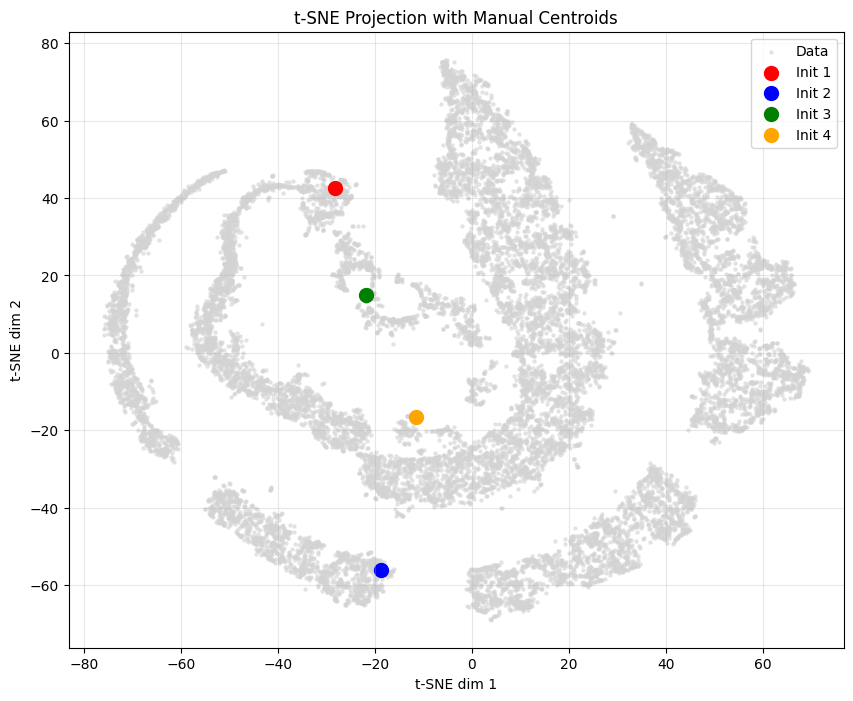

In [69]:
plt.figure(figsize=(10, 8))

# Plot original dataset
plt.scatter(proj_data[:, 0], proj_data[:, 1], c='lightgray', s=5, alpha=0.5, label='Data')

# Plot the two manually selected points
plt.scatter(proj_init[0, 0], proj_init[0, 1], c='red', s=100, label='Init 1')
plt.scatter(proj_init[1, 0], proj_init[1, 1], c='blue', s=100, label='Init 2')
plt.scatter(proj_init[2, 0], proj_init[2, 1], c='green', s=100, label='Init 3')
plt.scatter(proj_init[3, 0], proj_init[3, 1], c='orange', s=100, label='Init 4')


plt.legend()
plt.title("t-SNE Projection with Manual Centroids")
plt.xlabel("t-SNE dim 1")
plt.ylabel("t-SNE dim 2")
plt.grid(True, alpha=0.3)
plt.show()

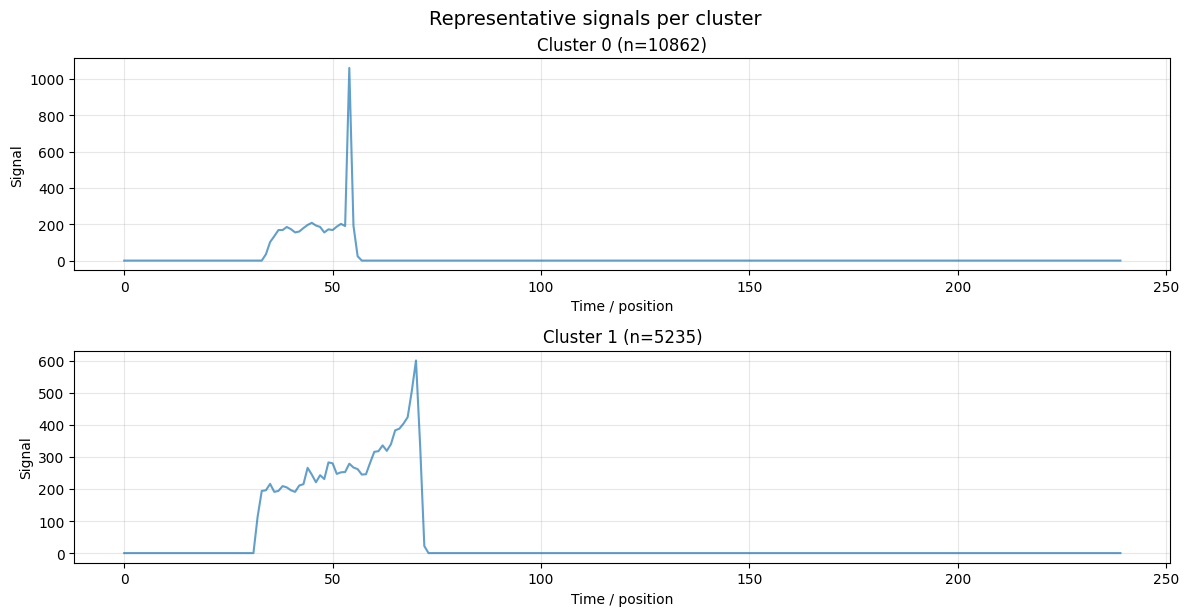

In [45]:
# ── prep data ──────────────────────────────────────────
X_np = X.cpu().numpy()            # original signals, shape (N, 240)
unique_labels = np.unique(labels) # e.g. [-1, 0, 1, 2, …]

# how many examples to show per cluster
n_plot = 1                     # adjust as you like

# set up a subplot row per cluster
n_rows = len(unique_labels)
fig, axes = plt.subplots(n_rows, 1, figsize=(12, 3 * n_rows))

if n_rows == 1:                   # when there’s only one cluster
    axes = [axes]

# ── loop over clusters ─────────────────────────────────
for ax, cid in zip(axes, unique_labels):
    mask   = labels == cid
    count  = mask.sum()
    sample = X_np[mask]

    # pick up to n_plot random examples
    k = min(n_plot, count)
    if k > 0:
        idx = np.random.choice(count, k, replace=False)
        for sig in sample[idx]:
            ax.plot(sig, alpha=0.7)

    title = f"Cluster {cid} (n={count})" if cid != -1 else f"Noise (n={count})"
    ax.set_title(title)
    ax.set_xlabel("Time / position")
    ax.set_ylabel("Signal")
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle("Representative signals per cluster", y=1.02, fontsize=14)
plt.show()

Testing on deuteron candidates

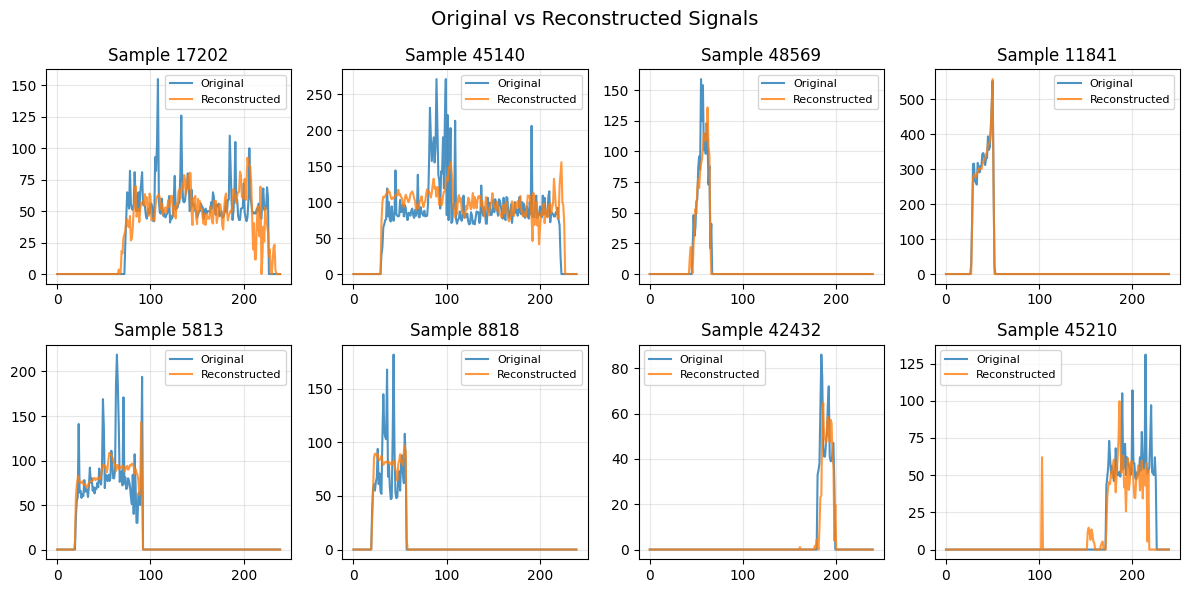

In [84]:
model.eval()

N = 8
X_cpu = Y.detach().cpu().numpy()             # full dataset, shape (N_total, 240)
sample_idx = np.random.choice(len(X_cpu), N, replace=False)
X_sample = Y[sample_idx].to(device)          # shape (N, 240)

# Run through model
with torch.no_grad():
    recons = model(X_sample).cpu().numpy()   # shape (N, 240)

# Original signals
X_orig = X_sample.cpu().numpy()

# Plot
plt.figure(figsize=(12, 6))
for i in range(N):
    plt.subplot(2, N // 2, i + 1)
    plt.plot(X_orig[i], label='Original', alpha=0.8)
    plt.plot(recons[i], label='Reconstructed', alpha=0.8)
    plt.title(f"Sample {sample_idx[i]}")
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=8)
plt.suptitle("Original vs Reconstructed Signals", fontsize=14)
plt.tight_layout()
plt.show()


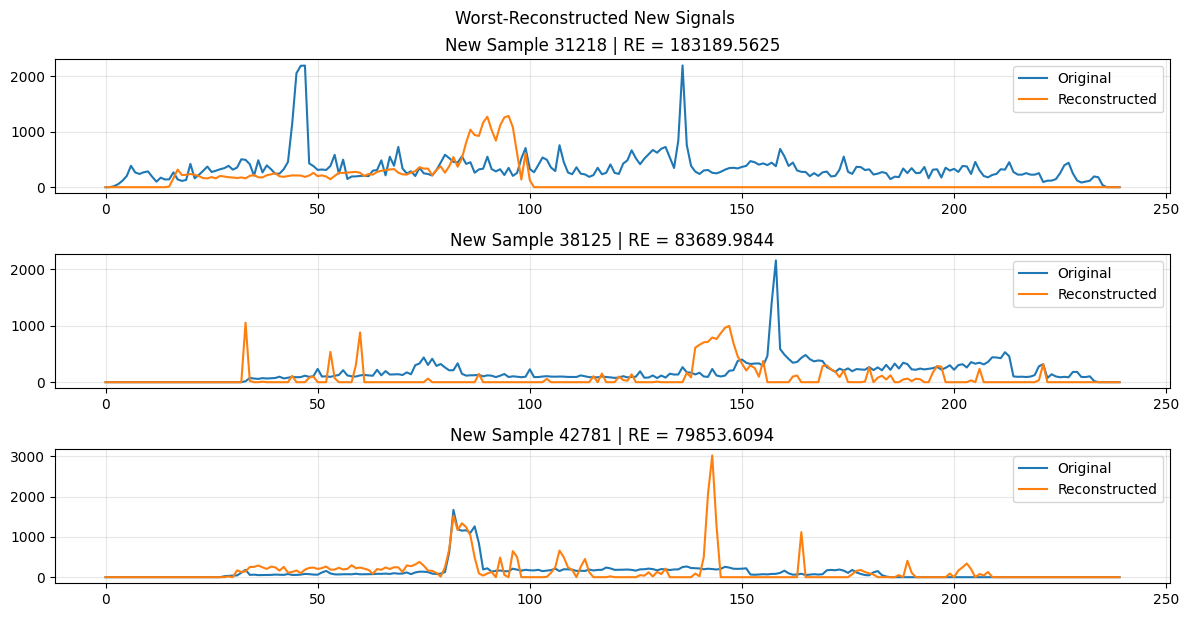

In [35]:
Y = torch.tensor(padded_deuterons, dtype=torch.float32).to(device)

model.eval()
with torch.no_grad():
    recons_new = model(Y)

re = F.mse_loss(recons_new, Y, reduction='none')  # (N, 240)
RE_per_sample = re.mean(dim=1).cpu().numpy()  # shape (N,)

top_n = 3
worst_indices = np.argsort(-RE_per_sample)[:top_n]

plt.figure(figsize=(12, 2 * top_n))
for i, idx in enumerate(worst_indices):
    plt.subplot(top_n, 1, i + 1)
    plt.plot(Y[idx].squeeze().cpu().numpy(), label='Original')
    plt.plot(recons_new[idx].squeeze().cpu().numpy(), label='Reconstructed')
    plt.title(f"New Sample {idx} | RE = {RE_per_sample[idx]:.4f}")
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle("Worst-Reconstructed New Signals", y=1.02)
plt.show()

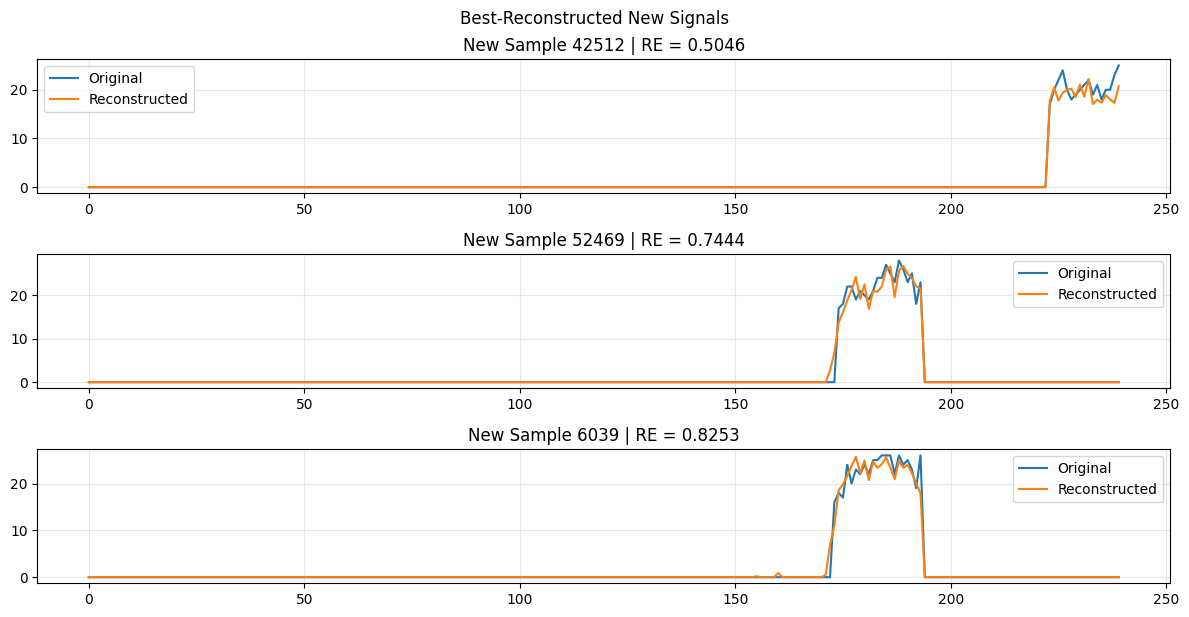

In [37]:
# Get indices of best-reconstructed samples (lowest RE)
best_n = 3
best_indices = np.argsort(RE_per_sample)[:best_n]  # ascending order

# Plot
plt.figure(figsize=(12, 2 * best_n))
for i, idx in enumerate(best_indices):
    plt.subplot(best_n, 1, i + 1)
    plt.plot(Y[idx].squeeze().cpu().numpy(), label='Original')
    plt.plot(recons_new[idx].squeeze().cpu().numpy(), label='Reconstructed')
    plt.title(f"New Sample {idx} | RE = {RE_per_sample[idx]:.4f}")
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle("Best-Reconstructed New Signals", y=1.02)
plt.show()

In [ ]:
with torch.no_grad():
    recons = model(Y)  # X shape: (N, 240)
    mse = F.mse_loss(recons, Y, reduction='none')  # shape (N, 240)
    RE_per_sample = mse.mean(dim=1).cpu().numpy()  # shape (N,)

with torch.no_grad():
    z_all = model.encoder(Y.unsqueeze(1))     # (N, 1, 240) → (N, 64, 60)
    z_all = z_all.flatten(1)                  # flatten to (N, 64*60)
    latent_vectors = model.fc_enc(z_all)      # (N, latent_dim)

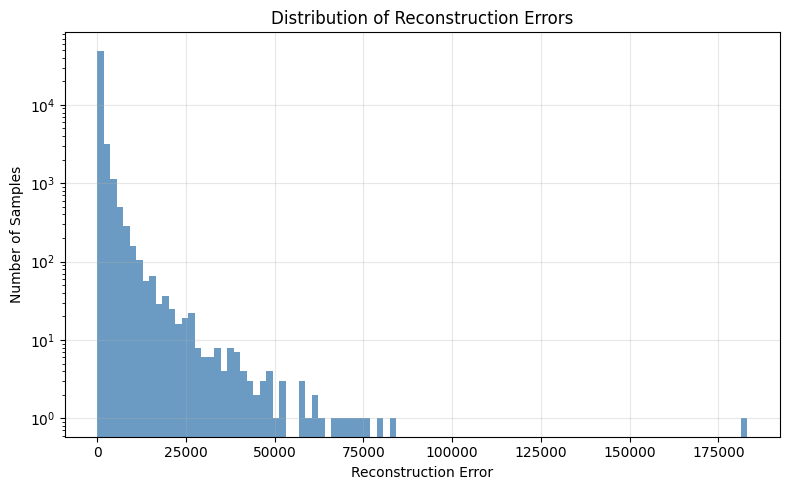

In [40]:
plt.figure(figsize=(8, 5))
plt.hist(RE_per_sample, bins=100, color='steelblue', alpha=0.8)
plt.xlabel("Reconstruction Error")
plt.ylabel("Number of Samples")
plt.title("Distribution of Reconstruction Errors")
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.tight_layout()
plt.show()

In [52]:
from sklearn.preprocessing import StandardScaler

features = np.concatenate([RE_per_sample.reshape(-1, 1), latent_vectors.cpu()], axis=1)

scaler   = StandardScaler()
X_scaled = scaler.fit_transform(features)

In [87]:
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=2000,     # tune 5–20
                            min_samples=500,        # default = min_cluster_size
                            metric='euclidean',
                            cluster_selection_method='eom')
labels = clusterer.fit_predict(X_scaled)             # -1 = noise
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(f"Found {n_clusters} clusters (+ noise)")


/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Found 2 clusters (+ noise)


In [88]:
from sklearn.manifold import TSNE

proj = TSNE(n_components=2, perplexity=30, random_state=0).fit_transform(X_scaled)


/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packag

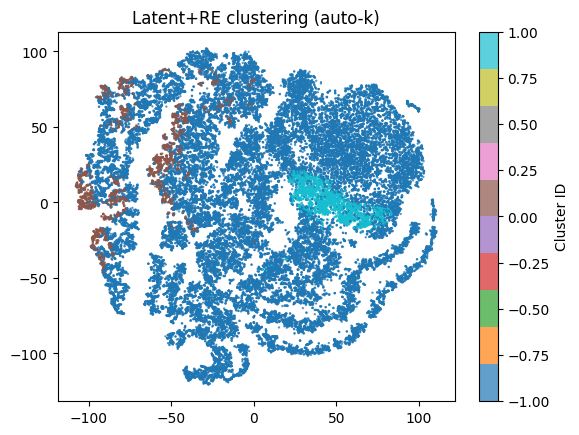

In [89]:
plt.scatter(proj[:, 0], proj[:, 1], c=labels, cmap='tab10', alpha=0.7, s=0.5)
plt.title("Latent+RE clustering (auto-k)")
plt.colorbar(label="Cluster ID")
plt.show()

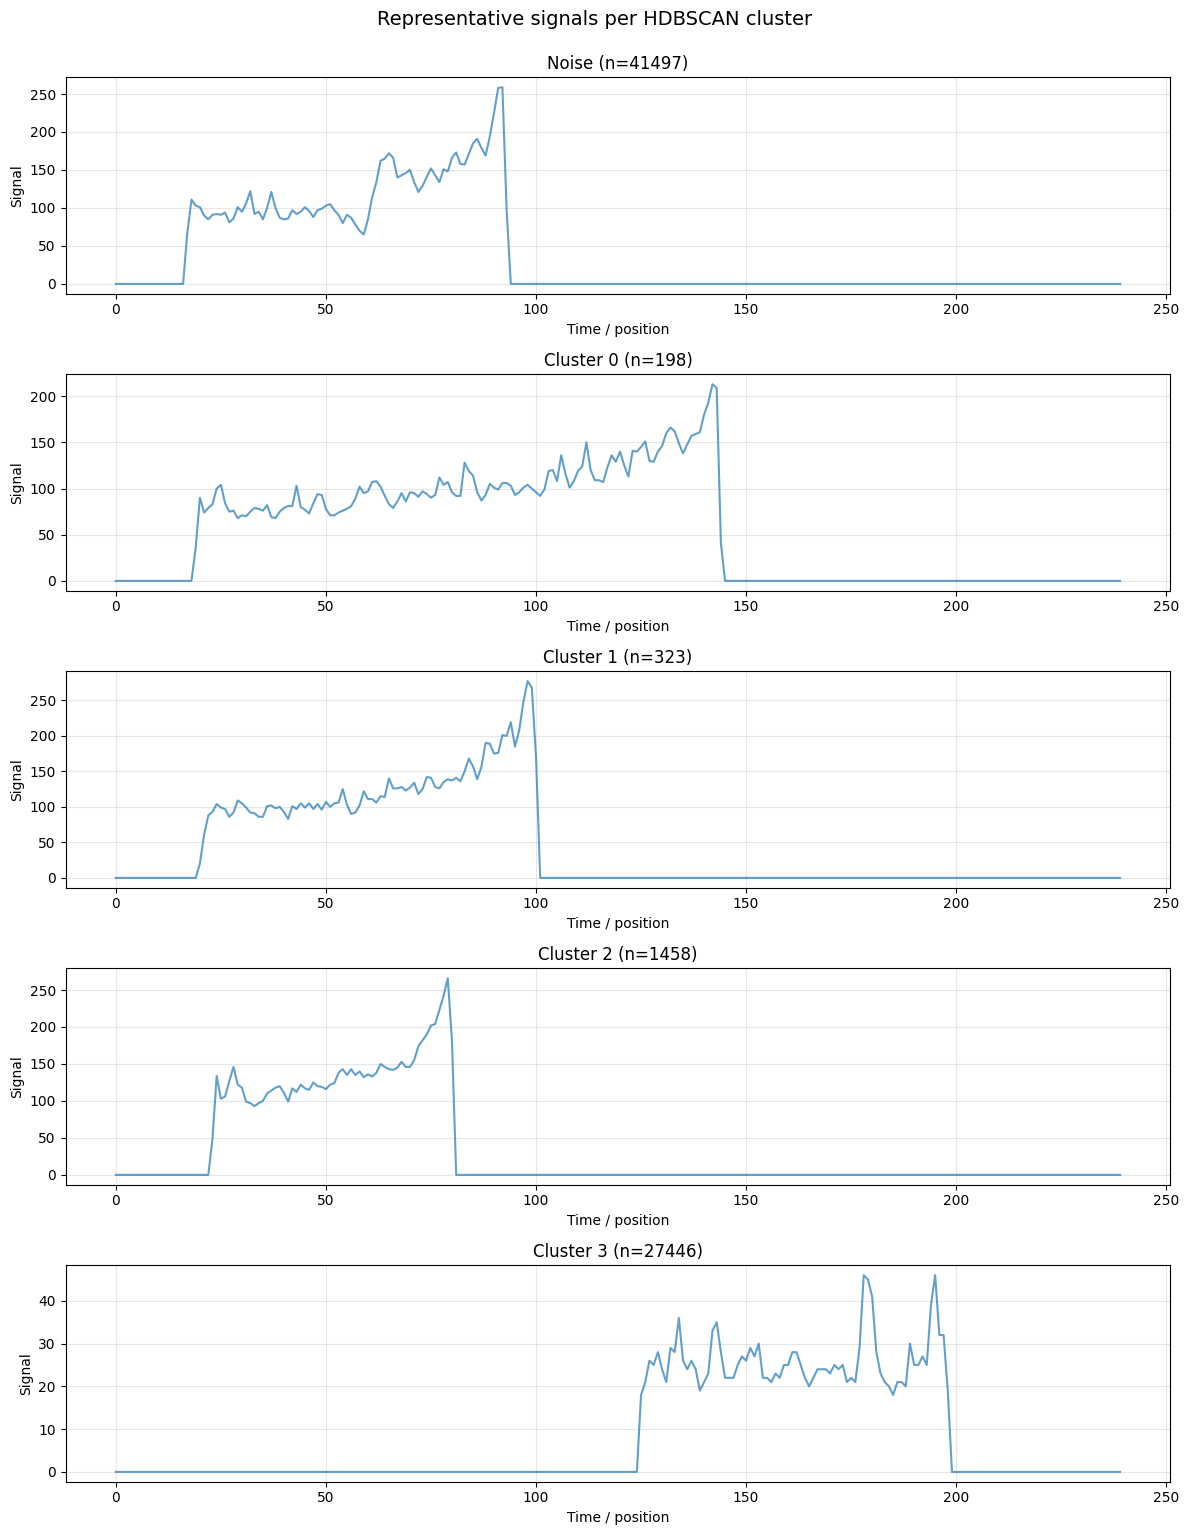

In [251]:
# ── prep data ──────────────────────────────────────────
X_np = X.cpu().numpy()            # original signals, shape (N, 240)
unique_labels = np.unique(labels) # e.g. [-1, 0, 1, 2, …]

# how many examples to show per cluster
n_plot = 1                     # adjust as you like

# set up a subplot row per cluster
n_rows = len(unique_labels)
fig, axes = plt.subplots(n_rows, 1, figsize=(12, 3 * n_rows))

if n_rows == 1:                   # when there’s only one cluster
    axes = [axes]

# ── loop over clusters ─────────────────────────────────
for ax, cid in zip(axes, unique_labels):
    mask   = labels == cid
    count  = mask.sum()
    sample = X_np[mask]

    # pick up to n_plot random examples
    k = min(n_plot, count)
    if k > 0:
        idx = np.random.choice(count, k, replace=False)
        for sig in sample[idx]:
            ax.plot(sig, alpha=0.7)

    title = f"Cluster {cid} (n={count})" if cid != -1 else f"Noise (n={count})"
    ax.set_title(title)
    ax.set_xlabel("Time / position")
    ax.set_ylabel("Signal")
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle("Representative signals per HDBSCAN cluster", y=1.02, fontsize=14)
plt.show()


Architecture experiments. 

- Need to be able to learn local features to be able to properly capture structure of muon signals - they fluctuate a lot. 

In [46]:
import torch, torch.nn as nn
# --------------------- utility blocks ---------------------
class SE1d(nn.Module):
    """Squeeze-and-Excitation for 1-D feature maps."""
    def __init__(self, ch, r=8):
        super().__init__()
        self.avg = nn.AdaptiveAvgPool1d(1)
        self.fc  = nn.Sequential(nn.Linear(ch, ch // r), nn.ReLU(), nn.Linear(ch // r, ch), nn.Sigmoid())

    def forward(self, x):
        w = self.avg(x).squeeze(-1)           # (B, C)
        w = self.fc(w).unsqueeze(-1)          # (B, C, 1)
        return x * w

class ResBlock(nn.Module):
    def __init__(self, ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(ch, ch, 3, padding=1), nn.BatchNorm1d(ch), nn.ReLU(),
            nn.Conv1d(ch, ch, 3, padding=1), nn.BatchNorm1d(ch)
        )
        self.se = SE1d(ch)

    def forward(self, x):
        return nn.functional.relu(self.se(self.net(x)) + x)

# --------------------- main model ---------------------
class CAE_UResSE(nn.Module):
    def __init__(self, input_len: int = 240, latent: int = 64):
        super().__init__()
        # ---------- Encoder ----------
        self.enc0 = nn.Sequential(                      # 240 → 120
            nn.Conv1d(1, 32, 15, stride=2, padding=7), nn.BatchNorm1d(32), nn.ReLU(), ResBlock(32)
        )
        self.enc1 = nn.Sequential(                      # 120 → 60
            nn.Conv1d(32, 64, 7, stride=2, padding=3), nn.BatchNorm1d(64), nn.ReLU(), ResBlock(64)
        )
        self.enc2 = nn.Sequential(                      # 60 → 30
            nn.Conv1d(64, 128, 5, stride=2, padding=2), nn.BatchNorm1d(128), nn.ReLU(), ResBlock(128)
        )
        self.enc3 = nn.Sequential(                      # 30 → 15
            nn.Conv1d(128, 256, 3, stride=2, padding=1), nn.BatchNorm1d(256), nn.ReLU(), ResBlock(256)
        )
        self.enc4 = nn.Sequential(                      # 15 → 14
            nn.Conv1d(256, 256, 2), nn.BatchNorm1d(256), nn.ReLU()
        )

        flat = 256 * 14
        self.fc_enc = nn.Linear(flat, latent)
        self.fc_dec = nn.Linear(latent, flat)

        # ---------- Decoder ----------
        self.up3 = nn.ConvTranspose1d(256, 128, 4, stride=2, padding=0) 
        self.up2 = nn.ConvTranspose1d(128, 64, 5, stride=2, padding=2, output_padding=1)   # 30 ← 60
        self.up1 = nn.ConvTranspose1d(64, 32, 7, stride=2, padding=3, output_padding=1)    # 60 ← 120
        self.up0 = nn.ConvTranspose1d(32, 1, 15, stride=2, padding=7, output_padding=1)    # 120 ← 240

        # post-concat refiners
        self.ref3 = ResBlock(128)
        self.ref2 = ResBlock(64)
        self.ref1 = ResBlock(32)

    def forward(self, x):                     # x: (B, 240)
        x = x.unsqueeze(1)                    # (B,1,240)

        s0 = self.enc0(x)                     # (B,32,120)
        s1 = self.enc1(s0)                    # (B,64,60)
        s2 = self.enc2(s1)                    # (B,128,30)
        s3 = self.enc3(s2)                    # (B,256,15)
        z  = self.enc4(s3).flatten(1)         # (B,3584)

        z  = self.fc_enc(z)                   # (B,latent)
        y  = self.fc_dec(z).view(x.size(0), 256, 14)

        y  = self.up3(y)                      # (B,128,30)
        y  = self.ref3(y + s2) # concat skip (128+128)

        y  = self.up2(y)                      # (B,64,60)
        y  = self.ref2(y + s1) # concat skip (64+64)

        y  = self.up1(y)                      # (B,32,120)
        y  = self.ref1(y + s0) # concat skip (32+32)

        y  = self.up0(y)                      # (B,1,240)
        return y.squeeze(1)                   # (B,240)


In [47]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device

device(type='mps')

In [48]:
model = CAE_UResSE().to(device)
optim  = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
loss_fn = nn.MSELoss()

In [49]:
X = torch.tensor(padded_all, dtype=torch.float32).to(device)
train_loader = torch.utils.data.DataLoader(X, batch_size=256, shuffle=True)
epochs = 300

In [50]:
for epoch in range(epochs):
    model.train()
    for xb in train_loader:
        xb = xb.to(device)
        optim.zero_grad()
        preds = model(xb)
        loss = loss_fn(preds, xb)
        loss.backward()
        optim.step()
    print(f"Epoch {epoch+1}: loss = {loss.item():.4f}")

Epoch 1: loss = 374.5507
Epoch 2: loss = 26.9414
Epoch 3: loss = 35.5079
Epoch 4: loss = 438.5383
Epoch 5: loss = 493.6346
Epoch 6: loss = 810.5446
Epoch 7: loss = 151.1898
Epoch 8: loss = 435.8657
Epoch 9: loss = 350.5735
Epoch 10: loss = 350.7113
Epoch 11: loss = 10.1531
Epoch 12: loss = 113.3566
Epoch 13: loss = 627.9992
Epoch 14: loss = 147.9059
Epoch 15: loss = 595.4627
Epoch 16: loss = 19.5068
Epoch 17: loss = 176.9924
Epoch 18: loss = 31.0452
Epoch 19: loss = 206.8282
Epoch 20: loss = 603.1510
Epoch 21: loss = 16.6899
Epoch 22: loss = 27.4987
Epoch 23: loss = 536.8291
Epoch 24: loss = 30.2955
Epoch 25: loss = 11.3206
Epoch 26: loss = 772.6556
Epoch 27: loss = 317.0933
Epoch 28: loss = 575.4115
Epoch 29: loss = 34.2513
Epoch 30: loss = 12.6524
Epoch 31: loss = 72.9269
Epoch 32: loss = 15.2599
Epoch 33: loss = 6.5064
Epoch 34: loss = 134.9118
Epoch 35: loss = 468.1456
Epoch 36: loss = 78.3167
Epoch 37: loss = 11.5162
Epoch 38: loss = 51.8058
Epoch 39: loss = 2.6423
Epoch 40: loss 

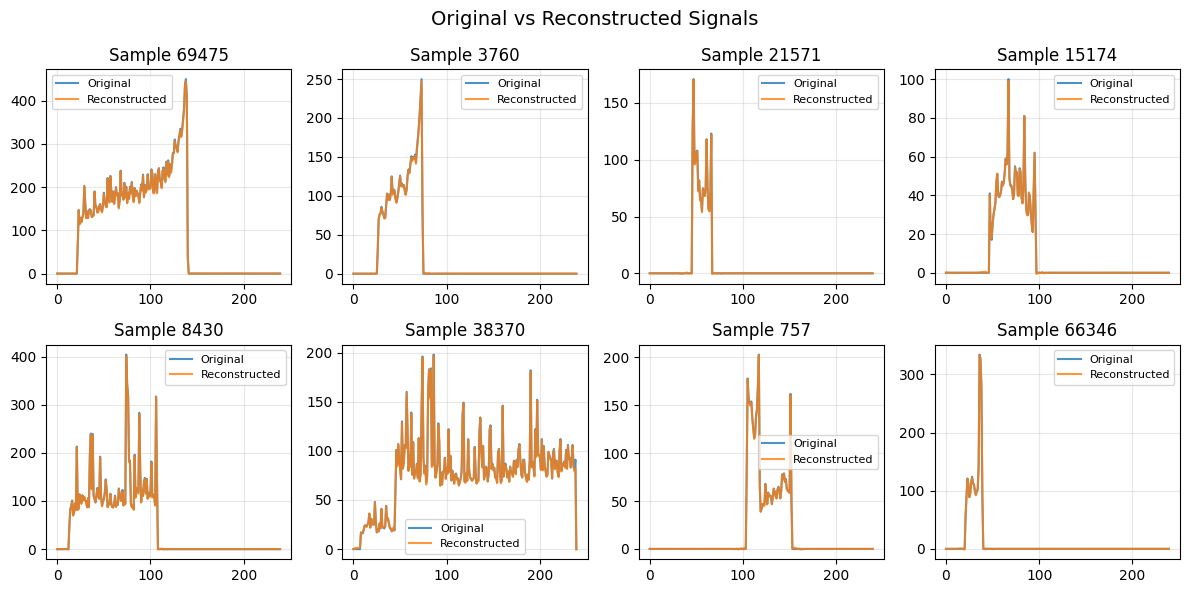

In [55]:
model.eval()

N = 8
X_cpu = X.detach().cpu().numpy()             # full dataset, shape (N_total, 240)
sample_idx = np.random.choice(len(X_cpu), N, replace=False)
X_sample = X[sample_idx].to(device)          # shape (N, 240)

# Run through model
with torch.no_grad():
    recons = model(X_sample).cpu().numpy()   # shape (N, 240)

# Original signals
X_orig = X_sample.cpu().numpy()

# Plot
plt.figure(figsize=(12, 6))
for i in range(N):
    plt.subplot(2, N // 2, i + 1)
    plt.plot(X_orig[i], label='Original', alpha=0.8)
    plt.plot(recons[i], label='Reconstructed', alpha=0.8)
    plt.title(f"Sample {sample_idx[i]}")
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=8)
plt.suptitle("Original vs Reconstructed Signals", fontsize=14)
plt.tight_layout()
plt.show()


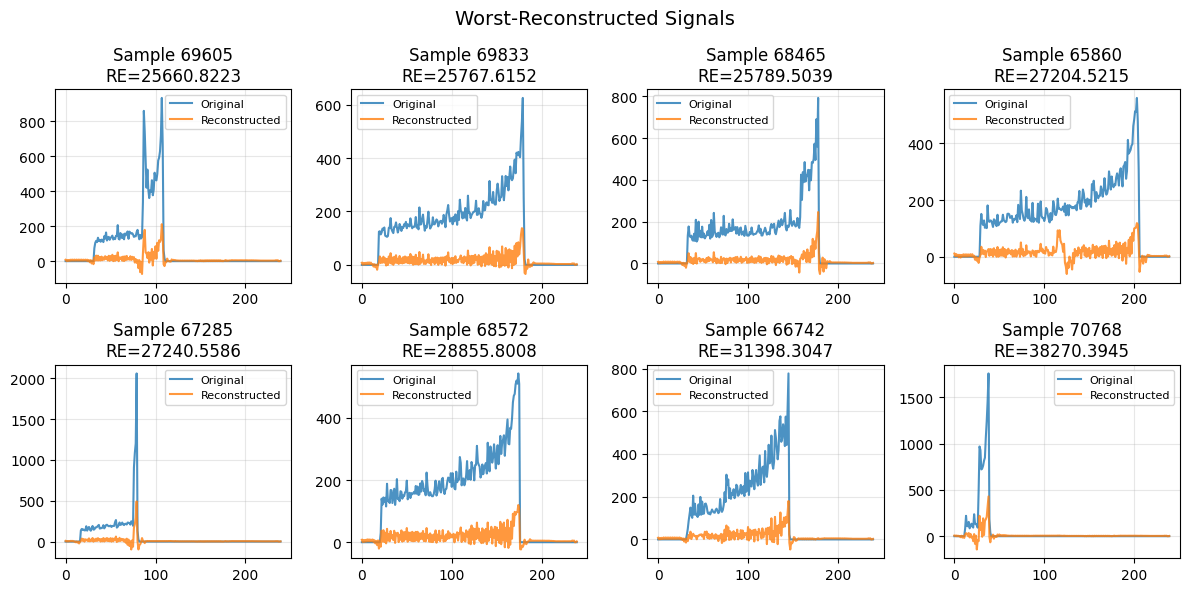

In [56]:
model.eval()

# Compute full reconstruction and REs
with torch.no_grad():
    recon_all = model(X)                  # shape (N, 240)
    re = F.mse_loss(recon_all, X, reduction='none')  # shape (N, 240)
    RE_per_sample = re.mean(dim=1).cpu().numpy()     # shape (N,)

# Sort by highest RE
worst_idx = np.argsort(RE_per_sample)[-8:]  # top 8 worst

# Get originals and recons
X_worst = X[worst_idx].cpu().numpy()
recon_worst = recon_all[worst_idx].cpu().numpy()

# Plot
plt.figure(figsize=(12, 6))
for i in range(len(worst_idx)):
    plt.subplot(2, 4, i + 1)
    plt.plot(X_worst[i], label='Original', alpha=0.8)
    plt.plot(recon_worst[i], label='Reconstructed', alpha=0.8)
    plt.title(f"Sample {worst_idx[i]}\nRE={RE_per_sample[worst_idx[i]]:.4f}")
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=8)
plt.suptitle("Worst-Reconstructed Signals", fontsize=14)
plt.tight_layout()
plt.show()



In [57]:
with torch.no_grad():
    recons = model(X)  # X shape: (N, 240)
    mse = F.mse_loss(recons, X, reduction='none')  # shape (N, 240)
    RE_per_sample = mse.mean(dim=1).cpu().numpy()  # shape (N,)

with torch.no_grad():
    x = X.unsqueeze(1)  # (N, 1, 240)

    s0 = model.enc0(x)
    s1 = model.enc1(s0)
    s2 = model.enc2(s1)
    s3 = model.enc3(s2)
    z  = model.enc4(s3)              # (N, 256, 14)

    z_flat = z.flatten(1)            # (N, 256 * 14)
    latent_vectors = model.fc_enc(z_flat).cpu().numpy()  # (N, latent)

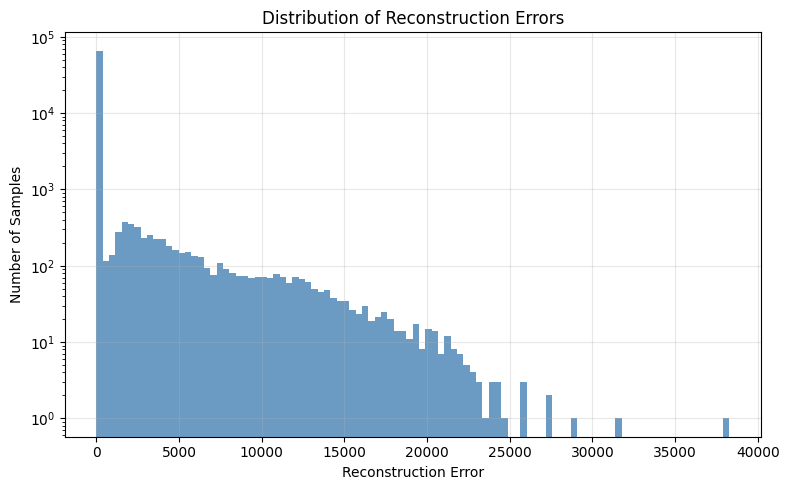

In [58]:
plt.figure(figsize=(8, 5))
plt.hist(RE_per_sample, bins=100, color='steelblue', alpha=0.8)
plt.xlabel("Reconstruction Error")
plt.ylabel("Number of Samples")
plt.title("Distribution of Reconstruction Errors")
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.tight_layout()
plt.show()

In [59]:
from sklearn.preprocessing import StandardScaler

features = latent_vectors

scaler   = StandardScaler()
X_scaled = scaler.fit_transform(features)

In [60]:
Z = X_scaled

In [63]:
import hdbscan
from sklearn.neighbors import NearestNeighbors

clusterer = hdbscan.HDBSCAN(
    min_cluster_size=200,         
    min_samples=100,
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=False         
).fit(Z)

labels = clusterer.labels_        # -1 = noise

# ----- 4.  Convert remaining noise to nearest cluster (optional) -----
noise_mask = labels == -1
if noise_mask.any():
    core_idx   = np.where(~noise_mask)[0]
    nneighbour         = NearestNeighbors(n_neighbors=1).fit(Z[core_idx])
    nearest    = nneighbour.kneighbors(Z[noise_mask], return_distance=False).ravel()
    labels[noise_mask] = labels[core_idx][nearest]

# labels now contains a cluster ID for every point
print(f"{np.unique(labels).size} clusters, { (clusterer.labels_ == -1).sum() } initial noise points")

/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


46 clusters, 0 initial noise points


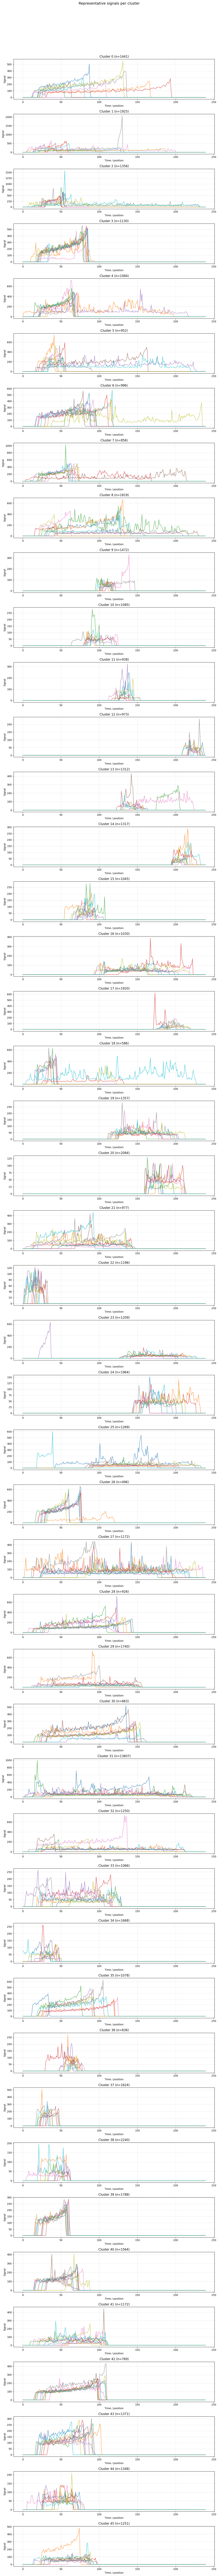

In [64]:
# ── prep data ──────────────────────────────────────────
X_np = X.cpu().numpy()            # original signals, shape (N, 240)
unique_labels = np.unique(labels) # e.g. [-1, 0, 1, 2, …]

# how many examples to show per cluster
n_plot = 10                     # adjust as you like

# set up a subplot row per cluster
n_rows = len(unique_labels)
fig, axes = plt.subplots(n_rows, 1, figsize=(12, 3 * n_rows))

if n_rows == 1:                   # when there’s only one cluster
    axes = [axes]

# ── loop over clusters ─────────────────────────────────
for ax, cid in zip(axes, unique_labels):
    mask   = labels == cid
    count  = mask.sum()
    sample = X_np[mask]

    # pick up to n_plot random examples
    k = min(n_plot, count)
    if k > 0:
        idx = np.random.choice(count, k, replace=False)
        for sig in sample[idx]:
            ax.plot(sig, alpha=0.7)

    title = f"Cluster {cid} (n={count})" if cid != -1 else f"Noise (n={count})"
    ax.set_title(title)
    ax.set_xlabel("Time / position")
    ax.set_ylabel("Signal")
    ax.grid(True, alpha=0.3)

plt.tight_layout()

plt.suptitle("Representative signals per cluster", y=1.02, fontsize=14)
plt.show()